#### Tools For Modern Macroeconometrics

## Term paper - 1st stage

##### Summer semester 2022/23

*Author:* Petr Čala
___
### *Environment preparation, package handling, and file validation:*

In [159]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE)

#Seed
set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod" # Period-over-period changes ("periodReturn")
)
# Other useful packages - "dplyr", "quantmod", "moments", "StableEstim", "stabledist", "tseries")

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)


[1] "Source file loaded."
[1] "Installing package strucchange..."


Installing package into 'C:/Users/hso20/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'strucchange' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hso20\AppData\Local\Temp\Rtmp8GTVFU\downloaded_packages


Loading required package: sandwich

Loading required package: TTR



[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

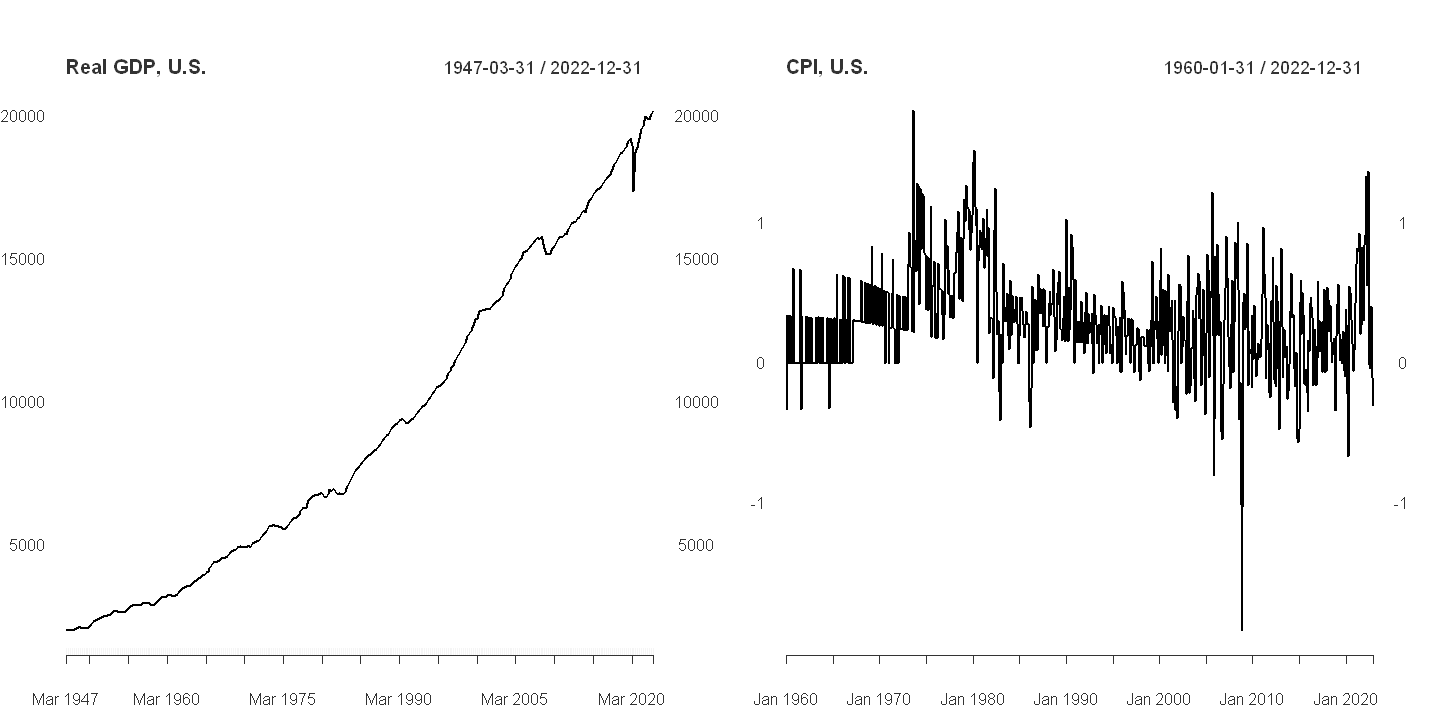

In [162]:
# Set the static variables
us_gdp_id <- "GDPC1"
us_cpi_id <- "CPALTT01USM657N"
start_date <- 2020
end_date <- 2023

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="Real GDP, U.S.", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S.", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

We transform the data according to the instructions. Most comments are provided inside the code block, but we would just like to mention, that the `seas` function did not work for us, thus we decided to go with the `decompose` function for seasonal trend extraction instead.

Also, the CPI data comes in the form of percentual changes as is, so there is no need to transform it, as it had already been done for us by the data provider.

In [168]:
### 1.
# Transform GDP into log
gdp_log <- log(us_gdp_data)
colnames(gdp_log) <- "GDP"


### 2.
# Adjust seasonality using ts_first_of_period, ts_ts, and decompose functions
cpi_ts <- ts_first_of_period(us_cpi_data)
cpi_ts <- ts_ts(cpi_ts)
cpi_seasonal <- decompose(cpi_ts) # $x, $seasonal, $trend, $random

# Extract the seasonal componenets
cpi_adjusted <- cpi_seasonal$x # Seasonally adjusted price index
cpi_seasonal_fluctuations <- cpi_seasonal$seasonal # Seasonal fluctuations

In [188]:
### 3. 
# Transform the cpi series back into xts for easier handling
cpi_dates <- index(us_cpi_data) # Use original dates
cpi_xts <- xts(cpi_adjusted, order.by = cpi_dates)
colnames(cpi_xts) <- "CPI"

## Period-over-period percentage changes
gdp_pop_change <- ROC(gdp_log, type='continuous') * 100
cpi_pop_change <- ROC(cpi_xts, type='continuous') * 100

## Year-over-year percentage changes
# Convert xts object to yearly frequency
gdp_yearly <- to.yearly(gdp_log)
cpi_yearly <- to.yearly(cpi_xts)

# Calculate year-on-year percentage changes for GDP and CPI
gdp_yoy_change <- ROC(gdp_yearly, type='continuous') * 100
cpi_yoy_change <- ROC(cpi_yearly, type='continuous') * 100

## Verify the presence of seasonal effect in the m-o-m transformed series

# Plot the periodogram of the m-o-m transformed series (CPI is monthly by default)
# START FIXING HERE
periodogram(cpi_pop_change, main='Periodogram of monthly CPI series')

# Plot the spectrum of the m-o-m transformed series
spectrum(cpi_pop_change, main='Spectrum of monthly CPI series')

##### STRUCCHANGE
library(strucchange)

# Detect structural breaks using the breakpoints function
bp <- breakpoints(xts_obj ~ 1)

# Test the stationarity of the segments between breakpoints
statcheck(bp)


### ADF
# Perform ADF test on the m-o-m transformed series
adf_test <- adf.test(pct_change)
if(adf_test$p.value < 0.05) {
  print('The m-o-m transformed series is stationary and has zero order of integration')
} else {
  # Perform ADF test on the first difference of the series
  adf_test_diff <- adf.test(diff(pct_change))
  if(adf_test_diff$p.value < 0.05) {
    print('The m-o-m transformed series is integrated of order 1')
  } else {
    print('The m-o-m transformed series is not stationary')
  }
}

# Perform ADF test on the y-o-y transformed series
adf_test_yoy <- adf.test(yoy_pct_change)
if(adf_test_yoy$p.value < 0.05) {
  print('The y-o-y transformed series is stationary and has zero order of integration')
} else {
  # Perform ADF test on the first difference of the series
  adf_test_yoy_diff <- adf.test(diff(yoy_pct_change))
  if(adf_test_yoy_diff$p.value < 0.05) {
    print('The y-o-y transformed series is integrated of order 1')
  }

ERROR: Error in periodogram(cpi_pop_change, main = "Periodogram of monthly CPI series"): could not find function "periodogram"


In [187]:
plot(cpi_pop_change)

ERROR: Error in plot.window(c(1, 10), c(NaN, NaN)): need finite 'ylim' values
